# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../../stork-1")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer


from tqdm import trange

using my stork version - reconstructive AE


## Generate Dataset

Specify the Dataset Parameters

In [2]:
nb_time_steps = 500
nb_units = 100
dt = 2e-3
n_samples = 100

nb_classes = 8

duration = nb_time_steps * dt
print(duration)

time_jitter = 3

1.0


In [3]:
# synchronous regular spikes
data = []
labels = []

# No time jitter
times = np.arange(0, nb_time_steps, 45).tolist()
nb_spikes = len(times)
times = sorted(times * nb_units)
times = torch.tensor(times, dtype=torch.float32)

units = np.arange(nb_units).tolist()
units = torch.tensor(units * nb_spikes)

# print(len(times))

data += [(times, units) for _ in range(n_samples)]
labels += [0 for _ in range(n_samples)]

# with time jitter
if time_jitter:
    times = times + torch.round(torch.randn_like(times) * time_jitter)
# print(len(times))

data += [(times, units) for _ in range(n_samples)]
labels += [1 for _ in range(n_samples)]

In [4]:
# asynchronous regular spikes
times = np.arange(nb_time_steps).tolist()
times = times * int((nb_spikes / 5))
times = torch.tensor(times, dtype=torch.float32)

nb_spikes_ar = len(times)

units = [u % nb_units for u in range(nb_spikes_ar//2)] + [(u+int(nb_units/2)) % nb_units for u in range(nb_spikes_ar//2)]
units = torch.tensor(units)

data += [(times, units) for _ in range(n_samples)]
labels += [2 for _ in range(n_samples)]


if time_jitter:
    times = times + torch.round(torch.randn_like(times) * time_jitter)


data += [(times, units) for _ in range(n_samples)]
labels += [3 for _ in range(n_samples)]

In [5]:
# synchronous irregular spikes

np.random.seed(14)

for _ in trange(n_samples):

    times = np.random.choice(np.arange(0, nb_time_steps), 10).tolist()
    nb_spikes = len(times)
    times = sorted(times * nb_units)
    times = torch.tensor(times, dtype=torch.float32)

    units = np.arange(nb_units).tolist()
    units = torch.tensor(units * nb_spikes)

    data += [(times, units)]


    # print(len(times))
labels += [4 for _ in range(n_samples)]

np.random.seed(14)

for _ in trange(n_samples):

    times = np.random.choice(np.arange(0, nb_time_steps), 10).tolist()
    nb_spikes = len(times)
    times = sorted(times * nb_units)
    times = torch.tensor(times, dtype=torch.float32)
    if time_jitter:
        times = times + torch.round(torch.randn_like(times) * time_jitter)

    units = np.arange(nb_units).tolist()
    units = torch.tensor(units * nb_spikes)

    data += [(times, units)]

    # print(len(times))
labels += [5 for _ in range(n_samples)]

100%|██████████| 100/100 [00:00<00:00, 2767.04it/s]


In [6]:
# asynchronous irregular spikes

torch.manual_seed(14)
for _ in range(n_samples):
    # get a tensor of shape nb_units x nb_time_steps
    activity = torch.rand(size=(nb_time_steps, nb_units))
    spikes = activity > 0.979
    times = np.where(spikes)[0].tolist()
    units = np.where(spikes)[1].tolist()

    times = torch.tensor(times, dtype=torch.float32)

    units = torch.tensor(units)

    data += [(times, units)]

    # print(len(times))
labels += [6 for _ in range(n_samples)]


torch.manual_seed(14)
for _ in range(n_samples+1):
    # get a tensor of shape nb_units x nb_time_steps
    activity = torch.rand(size=(nb_time_steps, nb_units))
    spikes = activity > 0.979
    times = np.where(spikes)[0].tolist()
    units = np.where(spikes)[1].tolist()

    times = torch.tensor(times, dtype=torch.float32)
    if time_jitter:
        times = times + torch.round(torch.randn_like(times) * time_jitter)

    units = torch.tensor(units)

    data += [(times, units)]

    # print(len(times))
labels += [7 for _ in range(n_samples+1)]

In [7]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_units, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    stork.datasets.RasDataset(ds, **ds_kwargs)
    for ds in stork.datasets.split_dataset(
        data, labels, splits=[0.9999, 0.0001], shuffle=False
    )
]
ds_train, _ = datasets

In [8]:
print(len(ds_train))
print(np.unique(ds_train.labels, return_counts=True))

800
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([100, 100, 100, 100, 100, 100, 100, 100]))


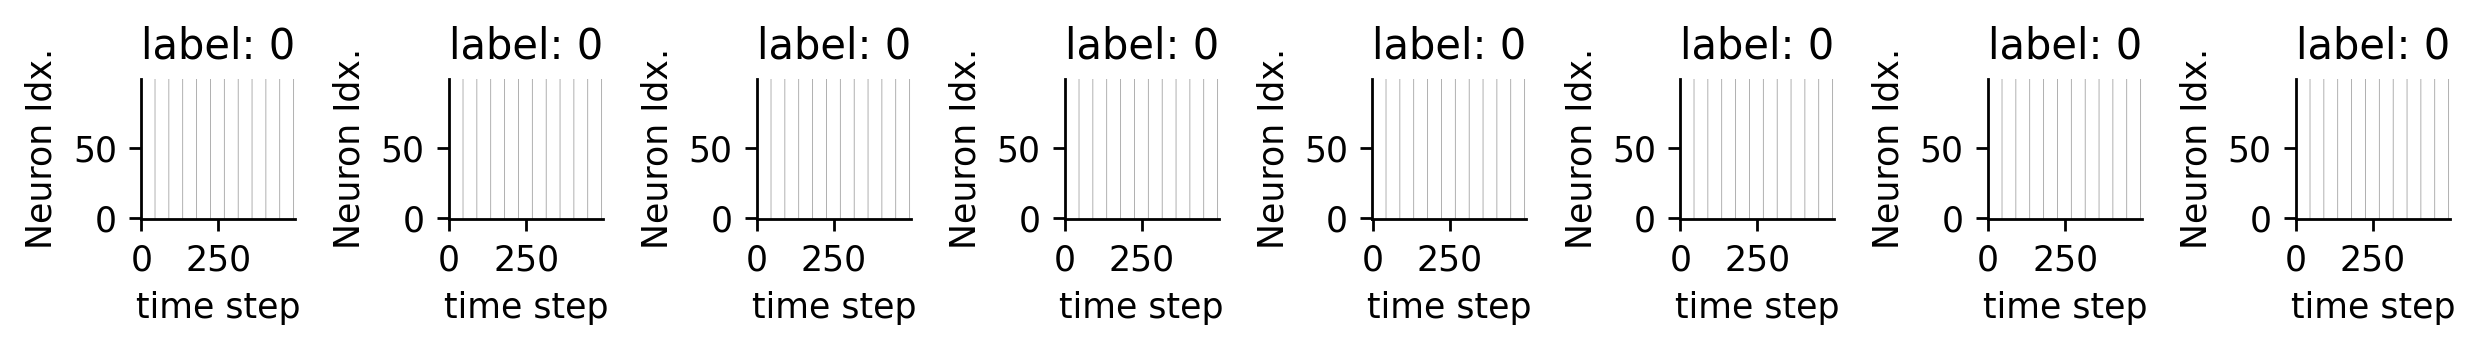

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(10, 1.5), dpi=250)
for i in range(8):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [10]:
# Model Parameters
batch_size = 50
nb_inputs = nb_units
beta = 5
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 5


In [11]:
act_fn = stork.activations.CustomSpike
act_fn.escape_noise_type = "step"
act_fn.escape_noise_params = {}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [12]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(nb_hidden_units, tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn)
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [13]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [14]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [15]:
sigma_u = 1.0
nu = nb_spikes / duration

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=1.0, nu=nu, timestep=dt
)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [16]:
for g in model.groups[:-2]:
    model.add_monitor(stork.monitors.SynchronyMonitor(g, name="synchrony" + g.name, bin_steps=2*time_jitter))
    model.add_monitor(
        stork.monitors.IrregularityMonitor(g, name="irregularity" + g.name, bin_steps=2*time_jitter)
    )

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [17]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [18]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [19]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

plotting


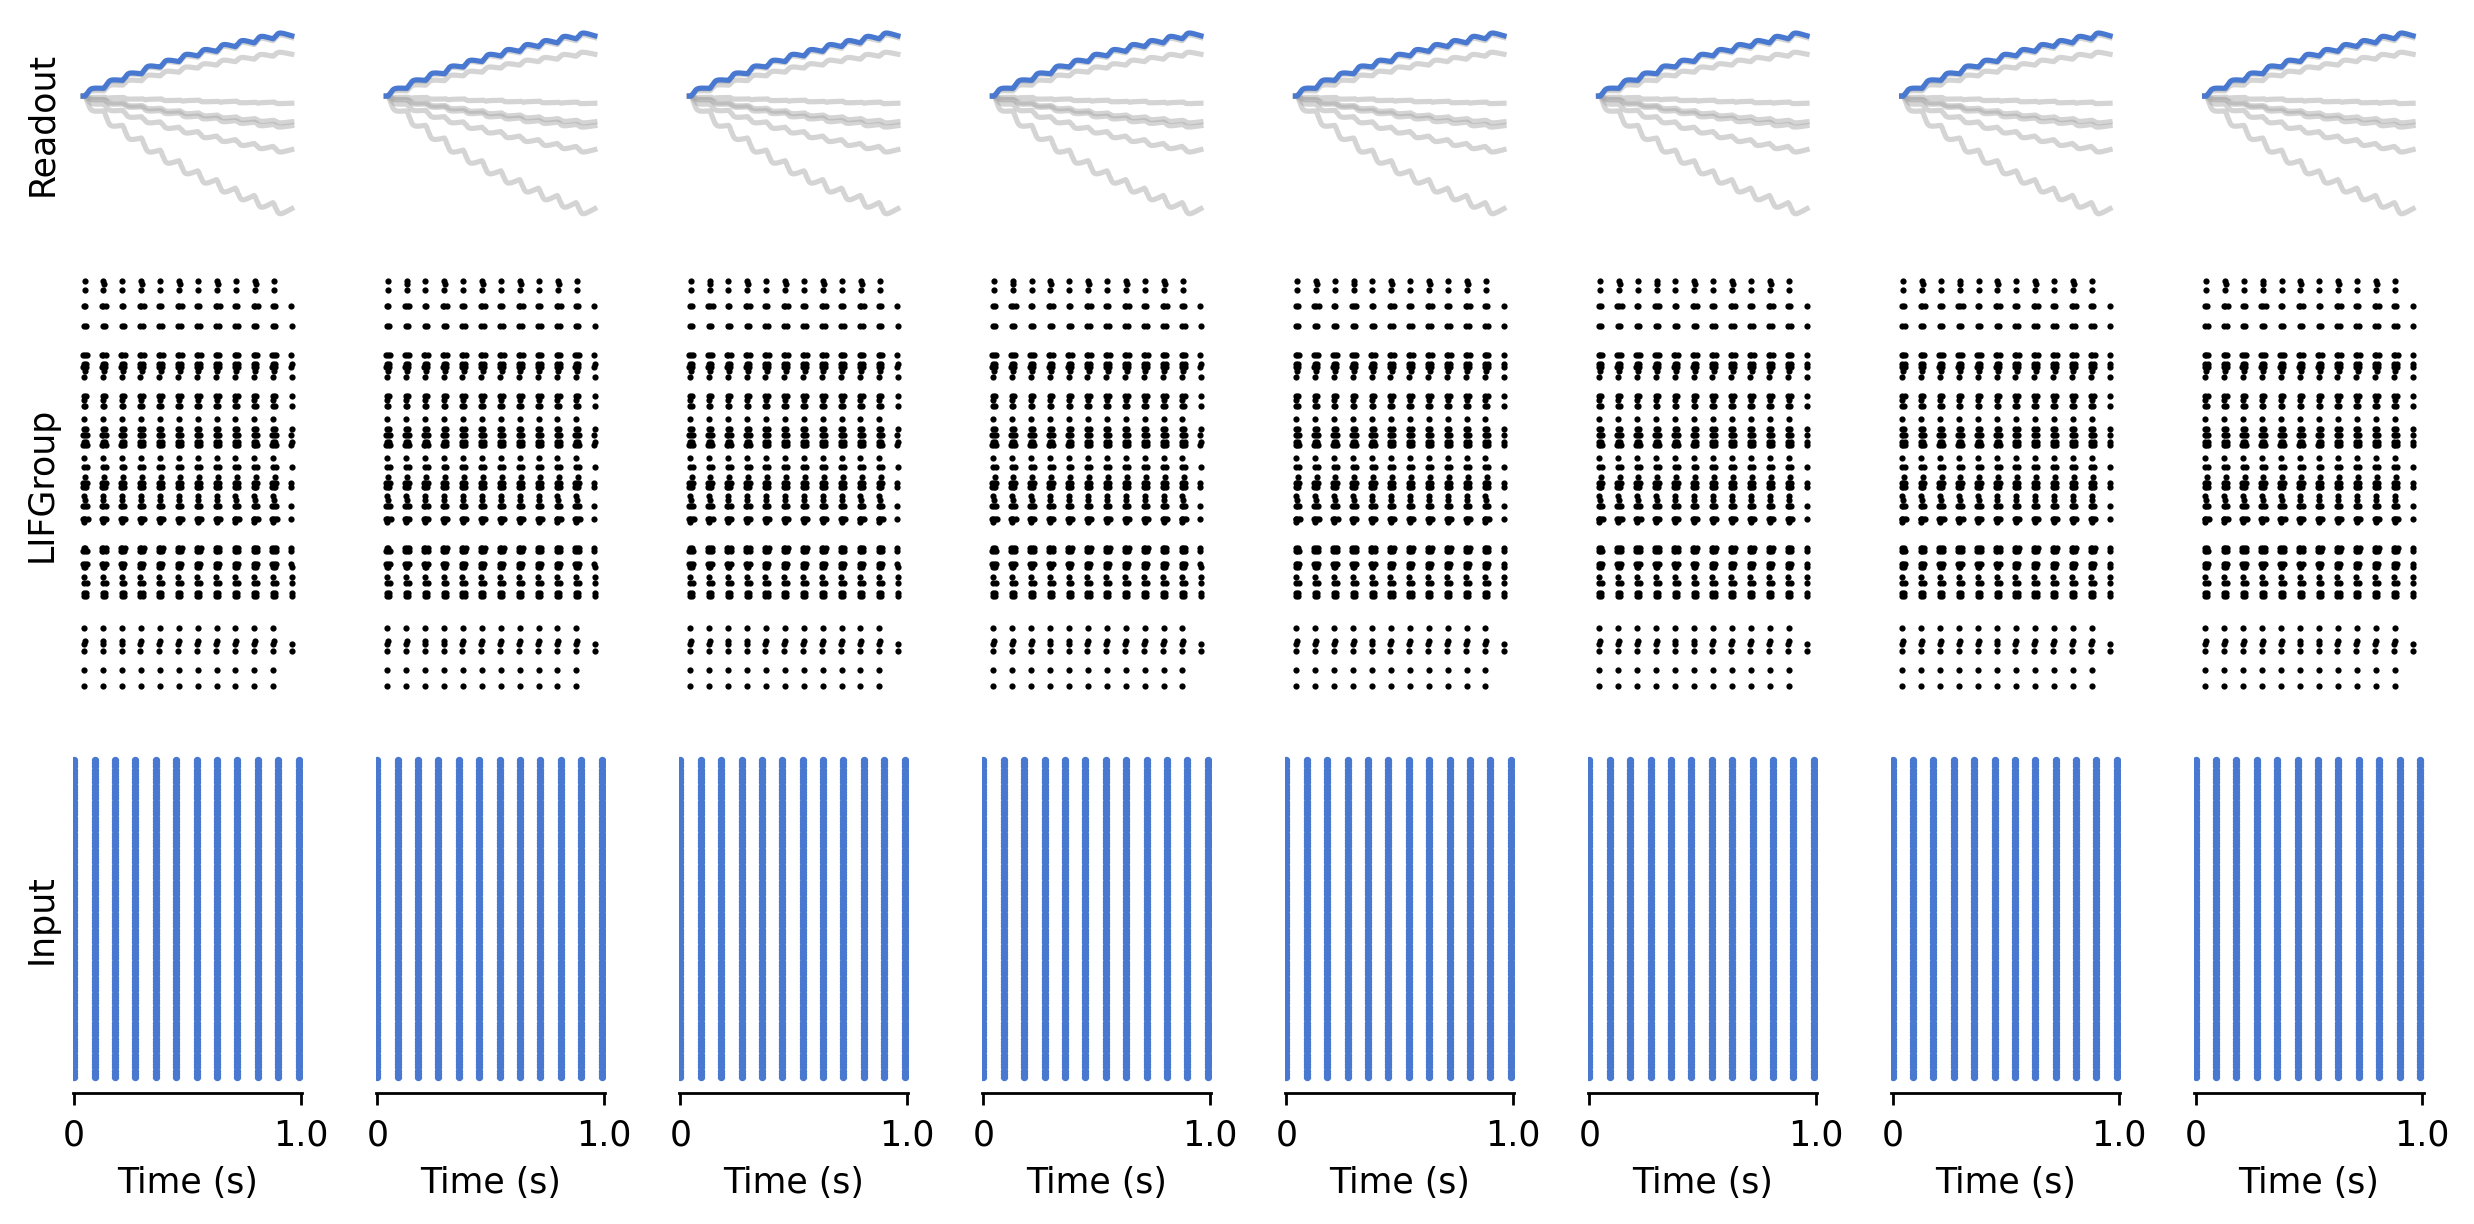

In [20]:
pl = stork.plotting_new.ActivityPlotter()
pl.plot_activity(
    model, data=ds_train, nb_samples=8, figsize=(10, 5), dpi=250, color_input=True
)

Before we train the model, we monitor the spikes

In [21]:
# Monitors spike counts before training
res = model.monitor(ds_train)

results = {}
for r, m in zip(res, model.monitors):
    print(m.name)
    results[m.name] = r

synchronyInput
irregularityInput


100 100
100 100
100 100
100 100


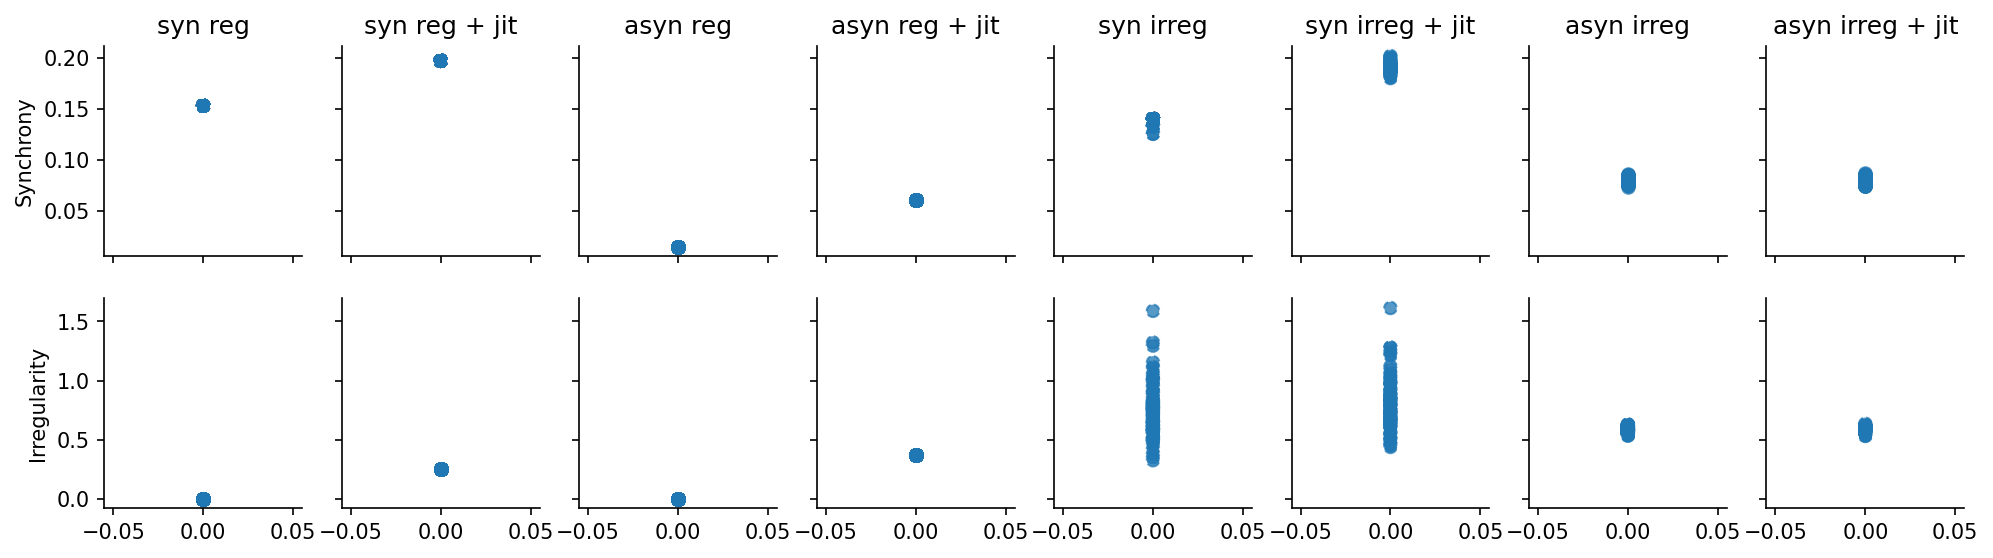

In [23]:
results.keys()

synch = {i: [] for i in range(nb_classes)}
irreg = {i: [] for i in range(nb_classes)}

for s, d in zip(results["synchronyInput"], ds_train):
    synch[d[1]].append(s)

for s, d in zip(results["irregularityInput"], ds_train):
    irreg[d[1]].append(s)

for i in range(4):
    print(len(synch[i]), len(irreg[i]))


legends = {0: "syn reg", 1: "asyn reg", 2: "syn irreg", 3: "asyn irreg"}
legends = {0: "syn reg", 1: "syn reg + jit", 2: "asyn reg", 3: "asyn reg + jit", 4: "syn irreg", 5: "syn irreg + jit", 6: "asyn irreg", 7: "asyn irreg + jit"}
fig, ax = plt.subplots(2, nb_classes, figsize=(nb_classes*2, 4), dpi=150, sharex=True, sharey="row")
for i in range(nb_classes):
    if "asyn" in legends[i]:
        ls_syn = "-"
    else:
        ls_syn = "--"
    if "irreg" in legends[i]:
        ls_reg = "--"
    else:
        ls_reg = "-"
    ax[0][i].scatter([0]*n_samples, [synch[i]], label=legends[i], alpha=0.75, ls=ls_syn)
    ax[1][i].scatter([0]*n_samples, [irreg[i]], label=legends[i], alpha=0.75, ls=ls_reg)

    ax[0][i].set_title(legends[i])


ax[0][0].set_ylabel("Synchrony")
ax[1][0].set_ylabel("Irregularity")

sns.despine()